# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

In [2]:
import albumentations as A
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import CIFAR10

class CustomDataset(Dataset):
    """
    Custom Dataset Class
    """
    def __init__(self, dataset, transforms=None):
        """Initialize Dataset
        Args:
            dataset (Dataset): Pytorch Dataset instance
            transforms (Transform.Compose, optional): Tranform function instance. Defaults to None.
        """
        self.transforms = transforms
        self.dataset = dataset

    def __len__(self):
        """Get dataset length
        Returns:
            int: Length of dataset
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """Get an item form dataset
        Args:
            idx (int): id of item in dataset
        Returns:
            (tensor, int): Return tensor of transformer image, label
        """
        # Read Image and Label
        image, label = self.dataset[idx]
        image = np.array(image)

        # Apply Transforms
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]

        return (image, label)


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [3]:
# Train Phase transformations
# Define the Albumentations transformations
train_transforms = A.Compose([
    A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
    A.PadIfNeeded(min_height=36, min_width=36, border_mode=0),
    A.RandomCrop(height=32, width=32),
    A.HorizontalFlip(p=0.5),
    A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=[0.4914, 0.4822, 0.4465]),
    ToTensorV2(),
])

# Test Phase transformations
test_transforms = A.Compose([
    A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
    ToTensorV2()
])


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# Dataset and Creating Train/Test Split

In [4]:
train_set = CustomDataset(
            datasets.CIFAR10("./data", train=True, download=True),
            transforms=train_transforms,
        )
test_set = CustomDataset(
            datasets.CIFAR10("./data", train=False, download=True),
            transforms=train_transforms,
        )

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

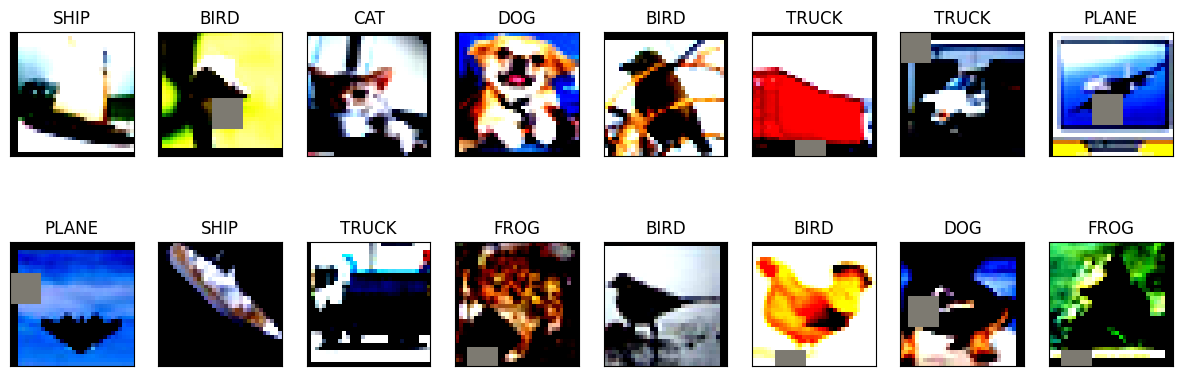

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import itertools
def print_samples(loader, class_map, count=16):
    """Print samples input images

    Args:
        loader (DataLoader): dataloader for training data
        count (int, optional): Number of samples to print. Defaults to 16.
    """
    # Print Random Samples
    if not count % 8 == 0:
        return

    classes = list(class_map.keys())
    fig = plt.figure(figsize=(15, 5))
    for imgs, labels in loader:
        for i in range(count):
            ax = fig.add_subplot(int(count / 8), 8, i + 1, xticks=[], yticks=[])
            ax.set_title(f"{classes[labels[i]]}")
            plt.imshow(imgs[i].cpu().numpy().transpose(1, 2, 0).astype(float))
        break
class_map = {
    "PLANE": 0,
    "CAR": 1,
    "BIRD": 2,
    "CAT": 3,
    "DEER": 4,
    "DOG": 5,
    "FROG": 6,
    "HORSE": 7,
    "SHIP": 8,
    "TRUCK": 9,
}

print_samples(train_loader, class_map)

# The model
Let's start with the model we first saw

In [8]:
from model import CustomResNet

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
         ResBlock-14          [-1,

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [14]:
from torch.optim.lr_scheduler import OneCycleLR

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# One Cycle Policy parameters
max_epoch = 24
max_lr = 0.1
total_steps = len(train_loader) * max_epoch
step_size_up = int(0.3 * total_steps)  # LR increase phase
step_size_down = total_steps - step_size_up  # LR decrease phase

# Create the OneCycleLR scheduler
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps,
                       pct_start=float(step_size_up) / total_steps, anneal_strategy='linear',
                       div_factor=max_lr / optimizer.defaults['lr'], final_div_factor=max_lr / optimizer.defaults['lr'])


In [ ]:

for epoch in range(max_epoch):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=-0.40802741050720215 Batch_id=390 Accuracy=43.16: 100%|██████████| 391/391 [00:25<00:00, 15.26it/s]



Test set: Average loss: -0.4326, Accuracy: 4344/10000 (43.44%)

EPOCH: 1


Loss=-0.398750364780426 Batch_id=390 Accuracy=43.75: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s]



Test set: Average loss: -0.4368, Accuracy: 4385/10000 (43.85%)

EPOCH: 2


Loss=-0.4799521565437317 Batch_id=390 Accuracy=47.76: 100%|██████████| 391/391 [00:25<00:00, 15.27it/s]



Test set: Average loss: -0.4959, Accuracy: 5000/10000 (50.00%)

EPOCH: 3


Loss=-0.5674128532409668 Batch_id=390 Accuracy=51.32: 100%|██████████| 391/391 [00:25<00:00, 15.17it/s]



Test set: Average loss: -0.5102, Accuracy: 5144/10000 (51.44%)

EPOCH: 4


Loss=-0.564704418182373 Batch_id=390 Accuracy=52.36: 100%|██████████| 391/391 [00:26<00:00, 14.89it/s]



Test set: Average loss: -0.5148, Accuracy: 5180/10000 (51.80%)

EPOCH: 5


Loss=-0.49171990156173706 Batch_id=390 Accuracy=52.90: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s]



Test set: Average loss: -0.5228, Accuracy: 5266/10000 (52.66%)

EPOCH: 6


Loss=-0.565666913986206 Batch_id=73 Accuracy=53.42:  19%|█▊        | 73/391 [00:04<00:19, 16.57it/s]

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
import torch.nn.functional as F
def get_incorrrect_predictions(model, loader, device):
    """Get all incorrect predictions

    Args:
        model (Net): Trained model
        loader (DataLoader): instance of data loader
        device (str): Which device to use cuda/cpu

    Returns:
        list: list of all incorrect predictions and their corresponding details
    """
    model.eval()
    incorrect = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            pred = output.argmax(dim=1)
            for d, t, p, o in zip(data, target, pred, output):
                if p.eq(t.view_as(p)).item() == False:
                    incorrect.append(
                        [d.cpu(), t.cpu(), p.cpu(), o[p.item()].cpu()])

    return incorrect


In [ ]:
incorrect = get_incorrrect_predictions(model, test_loader, device)

In [ ]:
def plot_incorrect_predictions(predictions, class_map, count=10):
    """Plot Incorrect predictions

    Args:
        predictions (list): List of all incorrect predictions
        class_map (dict): Lable mapping
        count (int, optional): Number of samples to print, multiple of 5. Defaults to 10.
    """
    print(f'Total Incorrect Predictions {len(predictions)}')

    if not count % 5 == 0:
        print("Count should be multiple of 10")
        return

    classes = list(class_map.keys())

    fig = plt.figure(figsize=(10, 5))
    for i, (d, t, p, o) in enumerate(predictions):
        ax = fig.add_subplot(int(count/5), 5, i + 1, xticks=[], yticks=[])
        ax.set_title(f'{classes[t.item()]}/{classes[p.item()]}')
        show_image = d.cpu().numpy().transpose(1, 2, 0)
        # Rescale the pixel values to [0, 1]
        show_image = (show_image - np.min(show_image)) / (np.max(show_image) - np.min(show_image))
        plt.imshow(show_image)
        if i+1 == 5*(count/5):
            break

In [ ]:
plot_incorrect_predictions(incorrect, class_map)